### Import Libraries

In [41]:
import pandas as pd
import numpy as np

import cv2
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import seaborn as sns

from zipfile import ZipFile

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import multiprocessing

from keras.applications import MobileNetV2, mobilenet_v2, ResNet50, resnet, vgg19

from sklearn.metrics import classification_report

import shutil
import csv

import glob
from IPython.display import Image, display

import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import the data.

In [ ]:
with ZipFile('/content/drive/MyDrive/AIML_CAPSTONE/Car+Images.zip', 'r') as z:
  z.extractall()

with ZipFile('/content/drive/MyDrive/AIML_CAPSTONE/Annotations.zip', 'r') as z:
  z.extractall()

#### Read Annotations Data

In [ ]:
anno_train = pd.read_csv("Annotations/Train Annotations.csv")
anno_test = pd.read_csv("Annotations/Test Annotation.csv")

In [ ]:
anno_train.head()

Image Name  Bounding Box coordinates  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0  00001.jpg                        39         116         569         375   
1  00002.jpg                        36         116         868         587   
2  00003.jpg                        85         109         601         381   
3  00004.jpg                       621         393        1484        1096   
4  00005.jpg                        14          36         133          99   

   Image class  
0           14  
1            3  
2           91  
3          134  
4          106

In [ ]:
anno_test.head()

Image Name  Bounding Box coordinates  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0  00001.jpg                        30          52         246         147   
1  00002.jpg                       100          19         576         203   
2  00003.jpg                        51         105         968         659   
3  00004.jpg                        67          84         581         407   
4  00005.jpg                       140         151         593         339   

   Image class  
0          181  
1          103  
2          145  
3          187  
4          185

In [ ]:
print("The shape of anno_train: ", anno_train.shape)
print("The shape of anno_test: ", anno_test.shape)

The shape of anno_train:  (8144, 6)
The shape of anno_test:  (8041, 6)


In [ ]:
col_names = ['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class'] # renaming columns

anno_train.columns = col_names
anno_test.columns = col_names

In [ ]:
anno_train.head()

image_name  xmin  ymin  xmax  ymax  class
0  00001.jpg    39   116   569   375     14
1  00002.jpg    36   116   868   587      3
2  00003.jpg    85   109   601   381     91
3  00004.jpg   621   393  1484  1096    134
4  00005.jpg    14    36   133    99    106

In [ ]:
anno_test.head()

image_name  xmin  ymin  xmax  ymax  class
0  00001.jpg    30    52   246   147    181
1  00002.jpg   100    19   576   203    103
2  00003.jpg    51   105   968   659    145
3  00004.jpg    67    84   581   407    187
4  00005.jpg   140   151   593   339    185

#### Read car names data and create dictionary with corresponding class number

In [ ]:
car_names = pd.read_csv("/content/drive/MyDrive/AIML_CAPSTONE/Car+names+and+make.csv", header=None)
car_names.loc[173][0] = "Ram C-V Cargo Van Minivan 2012"
car_names.head()

0
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

In [ ]:
# Create a dictionary to fetch car name easily from the class label
keys = list(range(1,197))
values = list(car_names[0])

car_names_dict = dict(zip(keys, values))
car_names_dict[1]

'AM General Hummer SUV 2000'

In [ ]:
TRAIN_FOLDER_PATH = 'Car Images/Train Images'
TEST_FOLDER_PATH = 'Car Images/Test Images'

## 2. Map training and testing images to its classes.
## 3. Map training and testing images to its annotations.
- Note that loading a large number of images into a dataframe or a numpy.array is not advisable. When we try to load all the images, RAM is overflowing. Hence, I gave a threshold 'max_images' to only load a limited number of images.
- For model training, we'll be using ImageDataGenerator to feed all the images to model during runtime. This is the ideal way rather than feeding it from dataframe.
- To access any image easily, we'll store image_path in train_metadata and test_metadata dataframes instead of storing the entire image.
- Doing both of the above questions in a single step.

In [ ]:
def load_images(path, max_images):

    images = []
    image_names = []

    for folder_name in os.listdir(path): # Iterate over each folder present in 'train' folder

        if not folder_name.startswith('.'): # Ignore hidden folders

            for file_name in os.listdir(os.path.join(path, folder_name)): # Iterate over each file

                img_path = os.path.join(path, folder_name, file_name) # Form image path

                img = cv2.imread(img_path)

                image_names.append(file_name)
                images.append(img)

                if(len(images) >= max_images): # Added this condition to load only limited number of images. To not overuse RAM.
                  return image_names, images    

#### Mapping train images to their class and annotations.

In [ ]:
train_image_names, train_images = load_images(path = TRAIN_FOLDER_PATH, max_images = 50) # load only 50 images

train_image_data = pd.DataFrame({
    'image_name': train_image_names, 
    'image': train_images})

train_image_data = train_image_data.merge(anno_train, on='image_name') # Map images to class and annotations

train_image_data['car_name'] = train_image_data['class'].map(car_names_dict)

train_image_data.head()

image_name                                              image  xmin  ymin  \
0  02642.jpg  [[[154, 153, 155], [147, 146, 148], [150, 149,...     9    12   
1  02261.jpg  [[[202, 161, 139], [198, 159, 137], [201, 161,...    76    31   
2  06367.jpg  [[[2, 8, 15], [2, 8, 15], [2, 8, 13], [1, 7, 1...    10    80   
3  03864.jpg  [[[33, 24, 27], [19, 21, 22], [12, 20, 20], [2...    40   101   
4  03873.jpg  [[[206, 226, 244], [206, 226, 244], [207, 227,...    15   111   

   xmax  ymax  class                  car_name  
0   595   354    185  Tesla Model S Sedan 2012  
1   574   261    185  Tesla Model S Sedan 2012  
2   576   317    185  Tesla Model S Sedan 2012  
3   549   360    185  Tesla Model S Sedan 2012  
4   489   258    185  Tesla Model S Sedan 2012

#### Mapping test images to their class and annotations.

In [ ]:
test_image_names, test_images = load_images(path = TEST_FOLDER_PATH, max_images = 50) # load only 50 images

test_image_data = pd.DataFrame({
    'image_name': test_image_names, 
    'image': test_images})

test_image_data = test_image_data.merge(anno_test, on='image_name') # Map images to class and annotations

test_image_data['car_name'] = test_image_data['class'].map(car_names_dict)

test_image_data.head()

image_name                                              image  xmin  ymin  \
0  05224.jpg  [[[190, 235, 255], [192, 235, 255], [192, 234,...    28    65   
1  04106.jpg  [[[218, 193, 177], [218, 193, 177], [218, 193,...    21   141   
2  02488.jpg  [[[233, 226, 207], [229, 222, 203], [227, 220,...    43    60   
3  05800.jpg  [[[243, 241, 241], [243, 241, 241], [243, 241,...    21   206   
4  04710.jpg  [[[70, 88, 125], [80, 98, 135], [89, 107, 144]...    75   214   

   xmax  ymax  class                  car_name  
0   572   374    185  Tesla Model S Sedan 2012  
1   573   321    185  Tesla Model S Sedan 2012  
2   595   322    185  Tesla Model S Sedan 2012  
3   605   422    185  Tesla Model S Sedan 2012  
4   594   494    185  Tesla Model S Sedan 2012

#### Load image metadata

In [ ]:
def load_image_metadata(path):

    image_paths = []
    image_names = []
    image_widths = []
    image_heights = []
    image_channels = []

    for folder_name in os.listdir(path): # Iterate over each folder present in 'train' folder

        if not folder_name.startswith('.'): # Ignore hidden folders

            for file_name in os.listdir(os.path.join(path, folder_name)): # Iterate over each file

                img_path = os.path.join(path, folder_name, file_name) # Form image path

                img = cv2.imread(img_path)

                image_paths.append(img_path)
                image_names.append(file_name)
                image_heights.append(img.shape[0])
                image_widths.append(img.shape[1])
                image_channels.append(img.shape[2])

    return image_paths, image_names, image_heights, image_widths, image_channels

In [ ]:
def load_metadata(path, annotations):
  
  image_metadata = load_image_metadata(path)
  metadata = pd.DataFrame({
      'image_path': image_metadata[0],
      'image_name': image_metadata[1], 
      'image_height': image_metadata[2], 
      'image_width': image_metadata[3], 
      'image_channels': image_metadata[4]})
  
  metadata = metadata.merge(annotations, on='image_name')
  
  metadata['car_name'] = metadata['class'].map(car_names_dict)
  
  return metadata

In [ ]:
train_metadata = load_metadata(TRAIN_FOLDER_PATH, anno_train)
train_metadata.head()

image_path image_name  image_height  \
0  Car Images/Train Images/Tesla Model S Sedan 20...  02642.jpg           356   
1  Car Images/Train Images/Tesla Model S Sedan 20...  02261.jpg           342   
2  Car Images/Train Images/Tesla Model S Sedan 20...  06367.jpg           352   
3  Car Images/Train Images/Tesla Model S Sedan 20...  03864.jpg           385   
4  Car Images/Train Images/Tesla Model S Sedan 20...  03873.jpg           333   

   image_width  image_channels  xmin  ymin  xmax  ymax  class  \
0          609               3     9    12   595   354    185   
1          600               3    76    31   574   261    185   
2          576               3    10    80   576   317    185   
3          580               3    40   101   549   360    185   
4          500               3    15   111   489   258    185   

                   car_name  
0  Tesla Model S Sedan 2012  
1  Tesla Model S Sedan 2012  
2  Tesla Model S Sedan 2012  
3  Tesla Model S Sedan 2012  
4  Tesla Model S Sedan 2012

In [ ]:
test_metadata = load_metadata(TEST_FOLDER_PATH, anno_test)
test_metadata.head()

image_path image_name  image_height  \
0  Car Images/Test Images/Tesla Model S Sedan 201...  05224.jpg           390   
1  Car Images/Test Images/Tesla Model S Sedan 201...  04106.jpg           371   
2  Car Images/Test Images/Tesla Model S Sedan 201...  02488.jpg           334   
3  Car Images/Test Images/Tesla Model S Sedan 201...  05800.jpg           480   
4  Car Images/Test Images/Tesla Model S Sedan 201...  04710.jpg           495   

   image_width  image_channels  xmin  ymin  xmax  ymax  class  \
0          590               3    28    65   572   374    185   
1          580               3    21   141   573   321    185   
2          630               3    43    60   595   322    185   
3          640               3    21   206   605   422    185   
4          640               3    75   214   594   494    185   

                   car_name  
0  Tesla Model S Sedan 2012  
1  Tesla Model S Sedan 2012  
2  Tesla Model S Sedan 2012  
3  Tesla Model S Sedan 2012  
4  Tesla Model S Sedan 2012

In [ ]:
train_metadata.shape

(8144, 11)

In [ ]:
test_metadata.shape

(8041, 11)

In [ ]:
def display_image(image_name, is_train=True):
  
  folder_path = TRAIN_FOLDER_PATH if is_train else TEST_FOLDER_PATH

  if(is_train):
    matching_row = train_metadata[train_metadata['image_name'] == image_name]
  else:
    matching_row = test_metadata[test_metadata['image_name'] == image_name]

  car_name = matching_row['car_name'].iloc[0]

  image_path = os.path.join(folder_path, car_name, image_name)

  
  img = cv2.imread(image_path)

  print('Name: ', car_name)
  print('Shape: ', img.shape)
  plt.imshow(img);
  plt.show()
  print()

Name:  Audi S5 Coupe 2012
Shape:  (420, 560, 3)


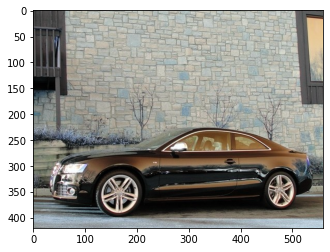


Name:  Ford F-450 Super Duty Crew Cab 2012
Shape:  (768, 1024, 3)


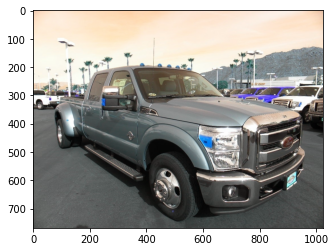


Name:  Dodge Caliber Wagon 2012
Shape:  (1080, 1920, 3)


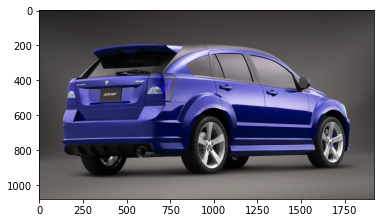


Name:  Lincoln Town Car Sedan 2011
Shape:  (242, 300, 3)


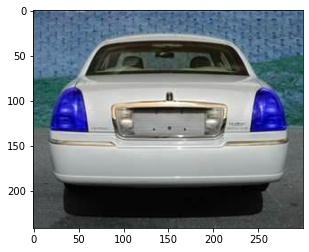


Name:  GMC Yukon Hybrid SUV 2012
Shape:  (480, 640, 3)


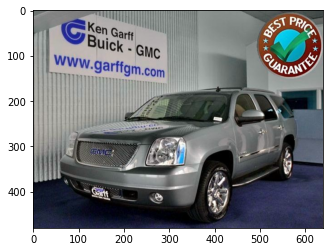

In [ ]:
for i in list(train_metadata.sample(5).image_name): # display 5 sample images
  display_image(i)

## 4. Display images with bounding box.

In [ ]:
def draw_bounding_box(image, bounding_box):

  img_rec = cv2.rectangle(image, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (255,0,0), 2)
  
  plt.imshow(img_rec);
    
  plt.show()

In [ ]:
def display_image_with_bounding_box(image_name, is_train=True):
  
  folder_path = TRAIN_FOLDER_PATH if is_train else TEST_FOLDER_PATH

  if(is_train):
    matching_row = train_metadata[train_metadata['image_name'] == image_name]
  else:
    matching_row = test_metadata[test_metadata['image_name'] == image_name]

  car_name = matching_row['car_name'].iloc[0]

  image_path = os.path.join(folder_path, car_name, image_name)
  bounding_box = [matching_row['xmin'].iloc[0], matching_row['ymin'].iloc[0], matching_row['xmax'].iloc[0], matching_row['ymax'].iloc[0]]

  img = cv2.imread(image_path)

  print('Name: ', car_name)
  print('Shape: ', img.shape)
  print('Bounding Box: ', bounding_box)
  
  draw_bounding_box(img, bounding_box)
  print()

Name:  Ford F-150 Regular Cab 2007
Shape:  (360, 480, 3)
Bounding Box:  [4, 42, 416, 345]


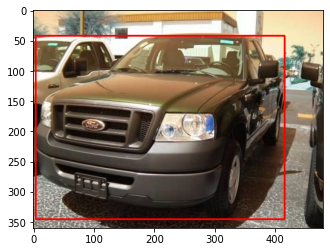


Name:  Acura TSX Sedan 2012
Shape:  (200, 300, 3)
Bounding Box:  [19, 49, 283, 191]


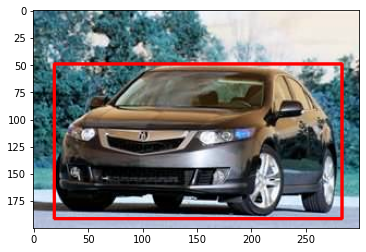


Name:  Bentley Continental GT Coupe 2012
Shape:  (213, 300, 3)
Bounding Box:  [12, 105, 282, 209]


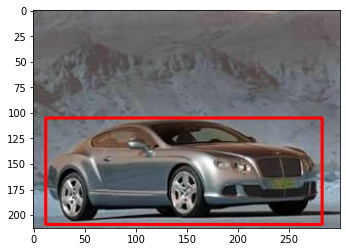


Name:  Honda Accord Coupe 2012
Shape:  (194, 259, 3)
Bounding Box:  [20, 54, 244, 154]


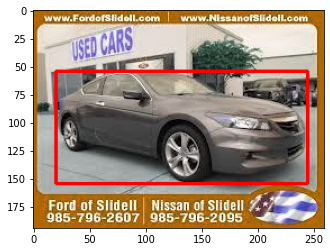


Name:  Dodge Challenger SRT8 2011
Shape:  (333, 500, 3)
Bounding Box:  [14, 77, 489, 287]


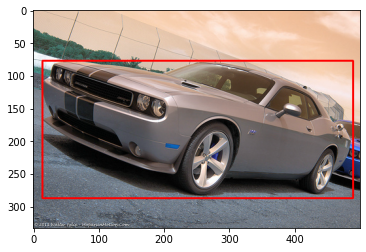

In [ ]:
for i in list(train_metadata.sample(5).image_name): # display 5 sample images with bounding box
  display_image_with_bounding_box(i)

### EDA

#### Check if any missing data 

In [ ]:
train_metadata.isnull().sum()

image_path        0
image_name        0
image_height      0
image_width       0
image_channels    0
xmin              0
ymin              0
xmax              0
ymax              0
class             0
car_name          0
dtype: int64

In [ ]:
test_metadata.isnull().sum()

image_path        0
image_name        0
image_height      0
image_width       0
image_channels    0
xmin              0
ymin              0
xmax              0
ymax              0
class             0
car_name          0
dtype: int64

In [ ]:
train_metadata.isna().sum()

image_path        0
image_name        0
image_height      0
image_width       0
image_channels    0
xmin              0
ymin              0
xmax              0
ymax              0
class             0
car_name          0
dtype: int64

In [ ]:
train_metadata.isna().sum()

image_path        0
image_name        0
image_height      0
image_width       0
image_channels    0
xmin              0
ymin              0
xmax              0
ymax              0
class             0
car_name          0
dtype: int64

- There are no missing values in both train and test dataset.

#### Analyse 5-number summary

In [ ]:
train_metadata.describe().transpose()

count        mean         std   min    25%    50%     75%  \
image_height    8144.0  482.771979  317.580021  57.0  290.0  424.0  540.00   
image_width     8144.0  699.793099  450.922445  78.0  429.0  636.5  800.00   
image_channels  8144.0    3.000000    0.000000   3.0    3.0    3.0    3.00   
xmin            8144.0   64.906803   82.198684   1.0   19.0   39.0   79.00   
ymin            8144.0  108.661223  104.551635   1.0   42.0   80.0  138.25   
xmax            8144.0  638.208620  410.776734  76.0  392.0  569.0  746.25   
ymax            8144.0  416.431606  273.786000  47.0  248.0  360.0  477.00   
class           8144.0   98.979371   56.503148   1.0   50.0   99.0  148.00   

                   max  
image_height    3744.0  
image_width     5616.0  
image_channels     3.0  
xmin            1648.0  
ymin            1508.0  
xmax            5205.0  
ymax            3389.0  
class            196.0

In [ ]:
test_metadata.describe().transpose()

count        mean         std   min    25%    50%    75%  \
image_height    8041.0  483.749658  319.083857  41.0  289.0  426.0  549.0   
image_width     8041.0  701.177092  455.601639  78.0  432.0  640.0  800.0   
image_channels  8041.0    3.000000    0.000000   3.0    3.0    3.0    3.0   
xmin            8041.0   65.057456   82.336438   1.0   19.0   39.0   78.0   
ymin            8041.0  107.816192  108.052354   1.0   40.0   79.0  137.0   
xmax            8041.0  639.433777  411.632197  72.0  395.0  575.0  748.0   
ymax            8041.0  417.301828  274.659479  41.0  249.0  364.0  478.0   
class           8041.0   98.975501   56.505578   1.0   51.0   99.0  148.0   

                   max  
image_height    5400.0  
image_width     7800.0  
image_channels     3.0  
xmin            1048.0  
ymin            1651.0  
xmax            7224.0  
ymax            3835.0  
class            196.0

#### Common observations on both train and test data:
-	The count is same for all the fields indicating no missing values.
-	The image_height, image_width, xmin, ymin, xmax, ymax have different means and std deviations indicating that all the images may not have the same shape.
-	Min and max values of class are 1 and 196 respectively indicating 196 total number of classes.
- For 'image_channels', both min and max are 3 and has no null values. All the train and test images have 3 channels only. Since it's constant, we can safely remove this column from both train_metadata and test_metadata. 


In [ ]:
train_metadata.drop('image_channels', axis=1, inplace=True)
test_metadata.drop('image_channels', axis=1, inplace=True)

#### Analysis on class distribution in both train and test sets.

In [ ]:
print('The number of unique cars in train set : ', train_metadata['car_name'].nunique())
print('The number of unique cars in test set : ', test_metadata['car_name'].nunique())

The number of unique cars in train set :  196
The number of unique cars in test set :  196


In [ ]:
train_metadata['car_name'].value_counts()

GMC Savana Van 2012                                    68
Chrysler 300 SRT-8 2010                                49
Mercedes-Benz 300-Class Convertible 1993               48
Mitsubishi Lancer Sedan 2012                           48
Jaguar XK XKR 2012                                     47
                                                       ..
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach Landaulet Convertible 2012                     29
FIAT 500 Abarth 2012                                   28
Hyundai Accent Sedan 2012                              24
Name: car_name, Length: 196, dtype: int64

In [ ]:
test_metadata['car_name'].value_counts()

GMC Savana Van 2012                                    68
Chrysler 300 SRT-8 2010                                48
Mercedes-Benz 300-Class Convertible 1993               48
Mitsubishi Lancer Sedan 2012                           47
Audi S6 Sedan 2011                                     46
                                                       ..
Rolls-Royce Phantom Drophead Coupe Convertible 2012    30
Maybach Landaulet Convertible 2012                     29
Chevrolet Express Cargo Van 2007                       29
FIAT 500 Abarth 2012                                   27
Hyundai Accent Sedan 2012                              24
Name: car_name, Length: 196, dtype: int64

In [ ]:
list(train_metadata['car_name'].unique()) # print all unique values

['Rolls-Royce Phantom Sedan 2012',
 'Acura Integra Type R 2001',
 'Hyundai Sonata Sedan 2012',
 'Chevrolet Malibu Hybrid Sedan 2010',
 'Ford Mustang Convertible 2007',
 'Dodge Ram Pickup 3500 Crew Cab 2010',
 'Mitsubishi Lancer Sedan 2012',
 'GMC Terrain SUV 2012',
 'Chevrolet Tahoe Hybrid SUV 2012',
 'Dodge Dakota Club Cab 2007',
 'Suzuki SX4 Sedan 2012',
 'Hyundai Accent Sedan 2012',
 'Acura TL Sedan 2012',
 'Honda Odyssey Minivan 2007',
 'Bentley Continental Supersports Conv. Convertible 2012',
 'Suzuki Aerio Sedan 2007',
 'Audi A5 Coupe 2012',
 'Dodge Dakota Crew Cab 2010',
 'Dodge Charger SRT-8 2009',
 'Audi S4 Sedan 2012',
 'Bentley Continental Flying Spur Sedan 2007',
 'Hyundai Veracruz SUV 2012',
 'Chevrolet Express Cargo Van 2007',
 'Hyundai Santa Fe SUV 2012',
 'Audi S5 Coupe 2012',
 'McLaren MP4-12C Coupe 2012',
 'Dodge Charger Sedan 2012',
 'Rolls-Royce Phantom Drophead Coupe Convertible 2012',
 'Chevrolet Silverado 1500 Extended Cab 2012',
 'Ford Fiesta Sedan 2012',
 'Niss

#### Class distribution in train data

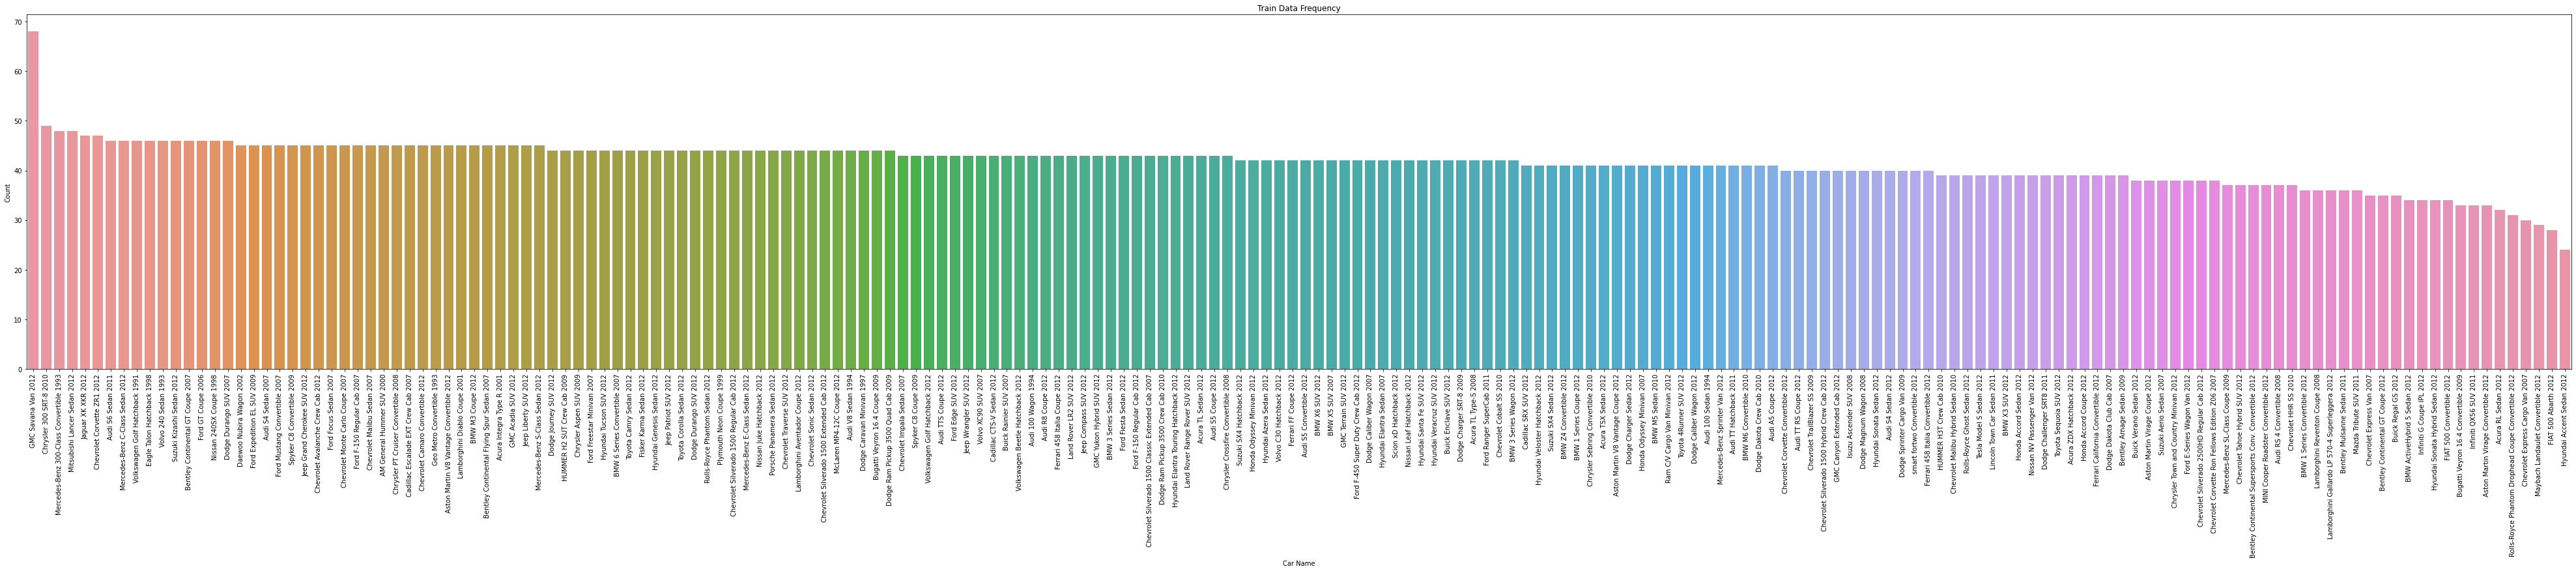

In [ ]:
rcParams['figure.figsize'] = 70,10

x = train_metadata['car_name'].value_counts()
labels = list(x.index)
values = list(x)

g = sns.barplot(x = labels, y = values)
g.set_xticklabels(labels=labels, rotation=90)

plt.xlabel('Car Name')
plt.ylabel('Count')
plt.title('Train Data Frequency')
plt.show()

#### Class distribution in test data

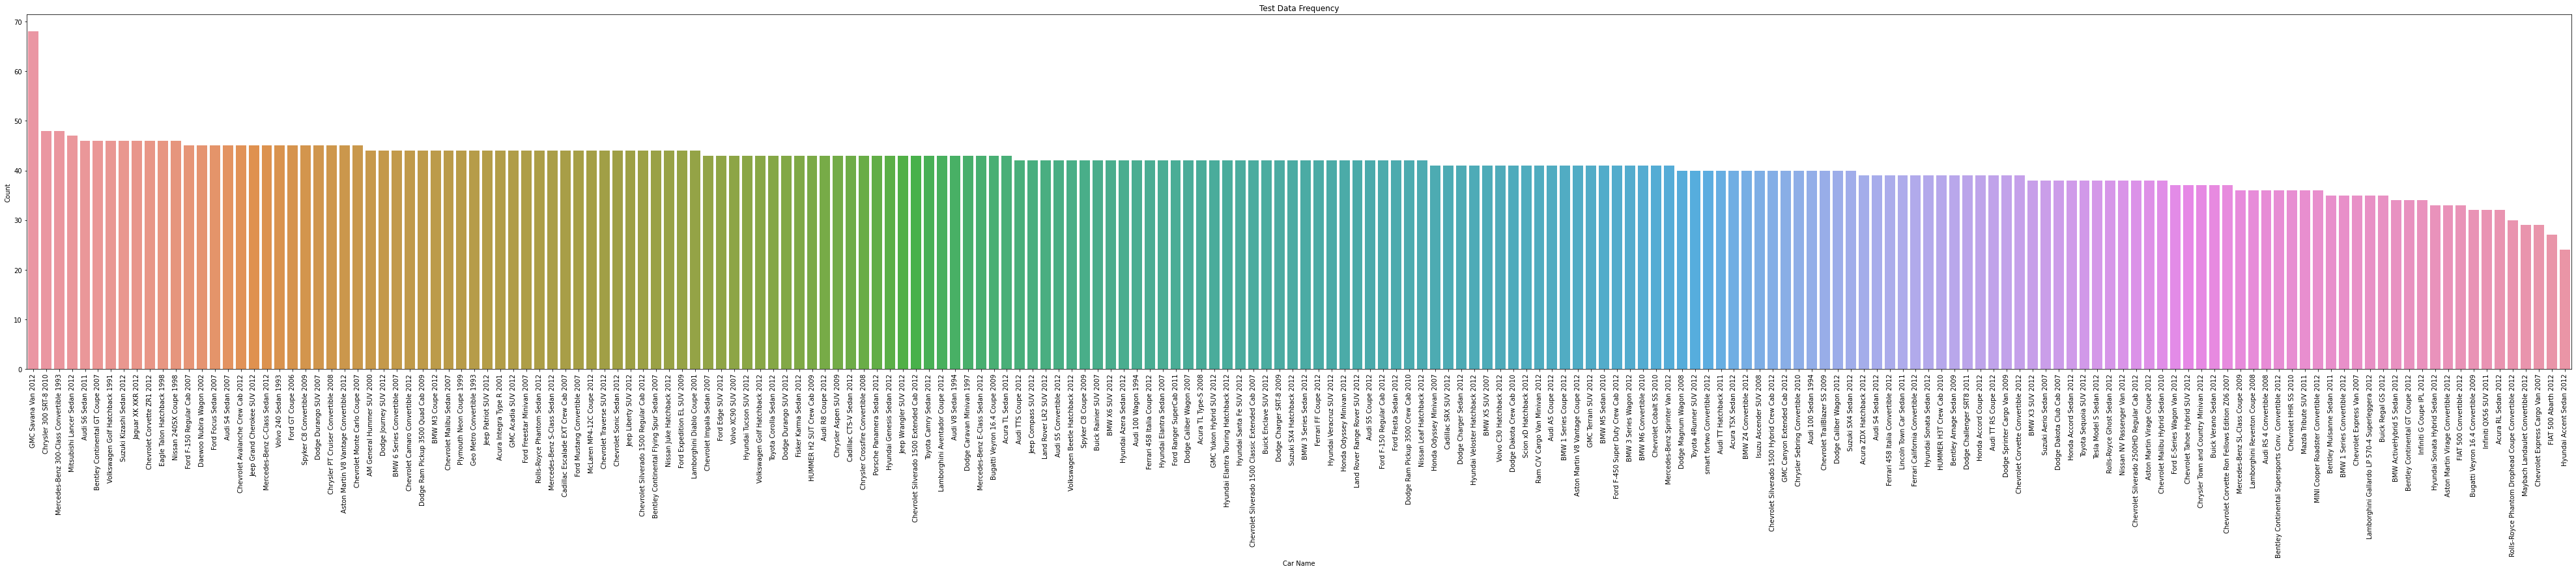

In [ ]:
rcParams['figure.figsize'] = 70,10

x = test_metadata['car_name'].value_counts()
labels = list(x.index)
values = list(x)

g = sns.barplot(x = labels, y = values)
g.set_xticklabels(labels=labels, rotation=90)

plt.xlabel('Car Name')
plt.ylabel('Count')
plt.title('Test Data Frequency')
plt.show()

#### Observations
- The total number of images per class are slightly varying within the train and test sets, but for a given class, the number of images in train and test sets is similar. 
- For eg, The highest number of images are present for the car ‘GMC Savana Van 2012’ in both train and test sets and the lowest number of images are present for the car ‘Hyundai Accent Sedan 2012 in both train and test sets. 
- This indicates that the class imabalance does not affect the model much and do not make the model unfairly biased.

#### Train Images Metadata Pairplot

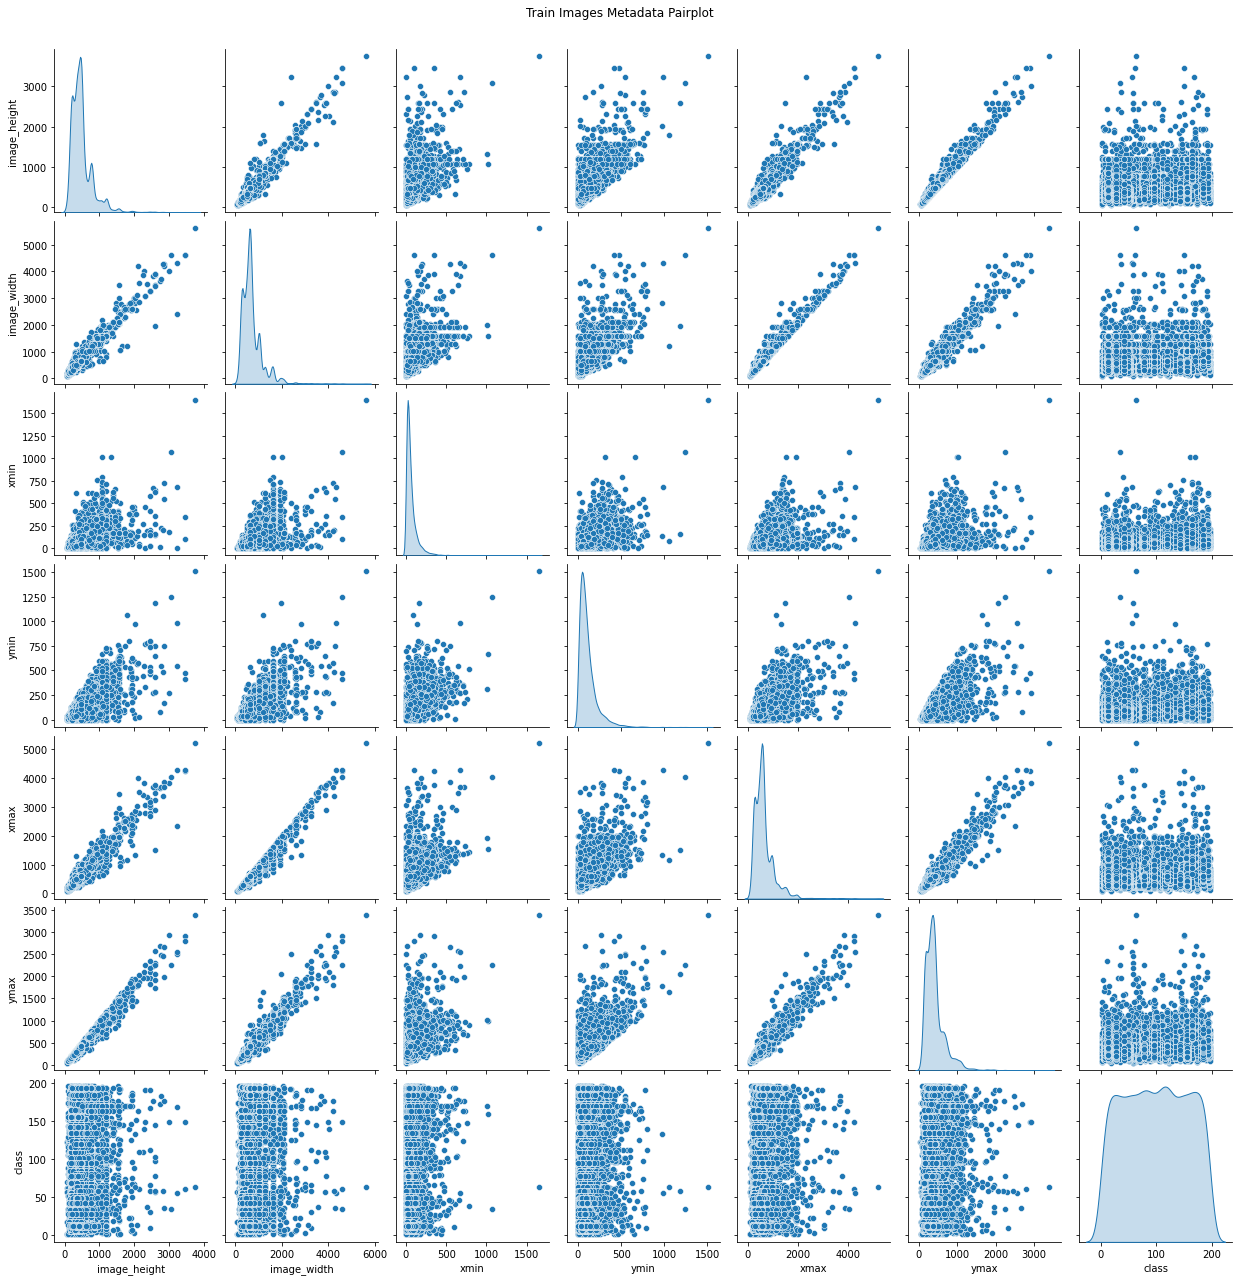

In [ ]:
g = sns.pairplot(train_metadata, diag_kind='kde')
g.fig.suptitle("Train Images Metadata Pairplot", y=1.02)
plt.show()

#### Test Images Metadata Pairplot

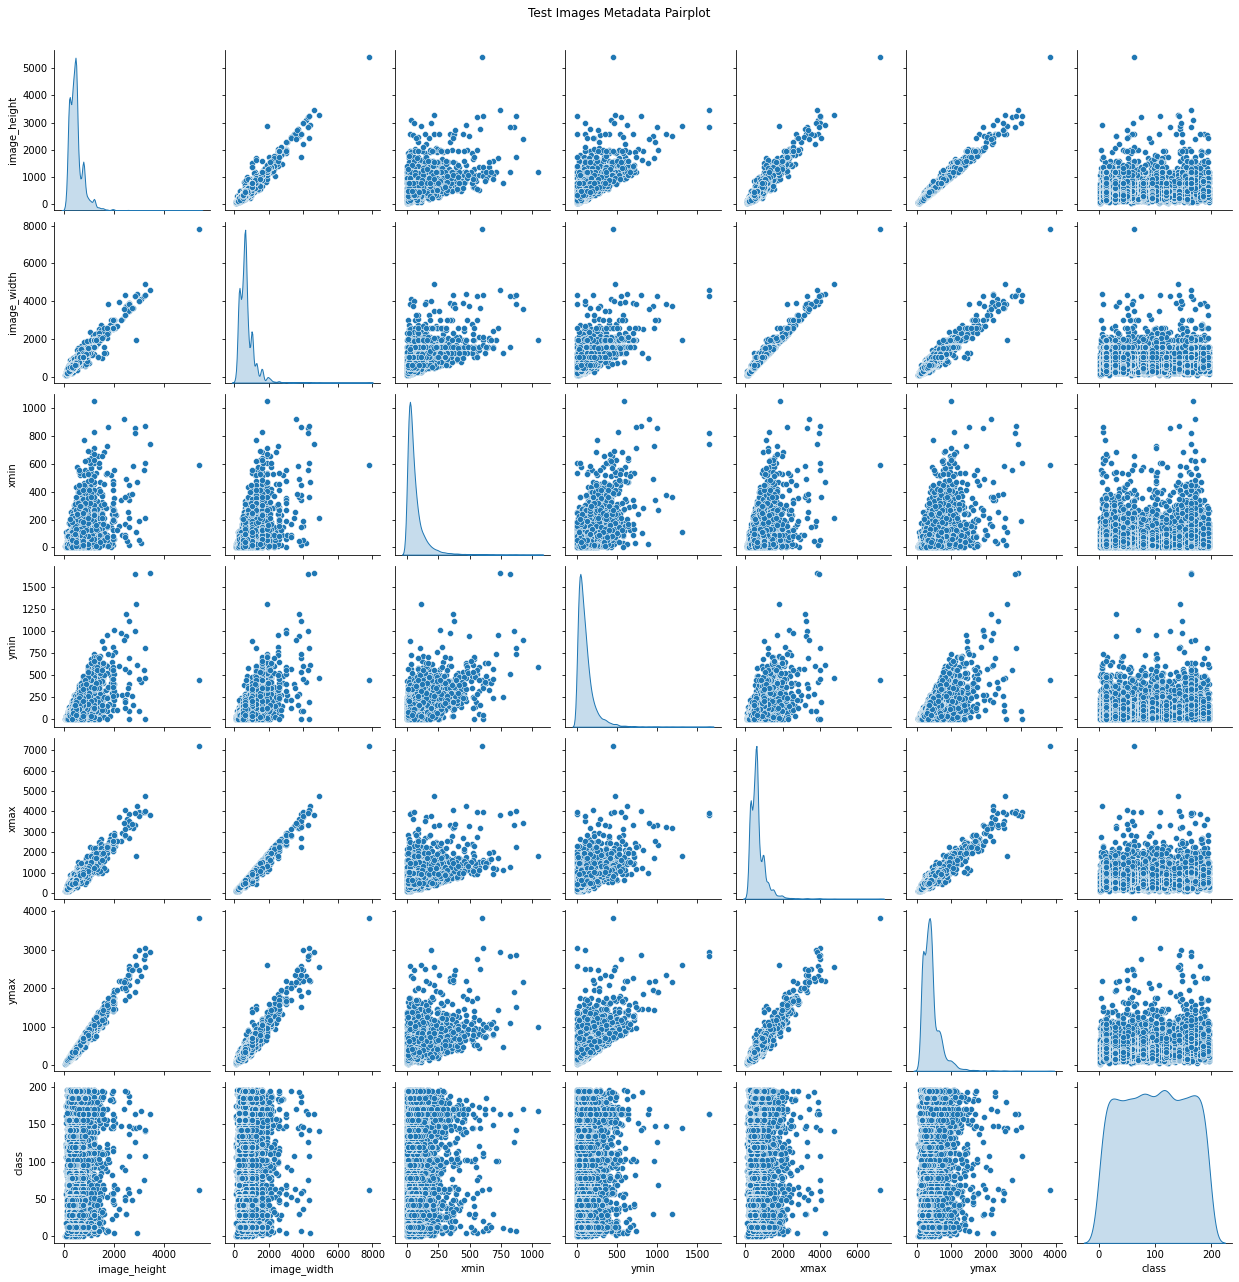

In [ ]:
g = sns.pairplot(test_metadata, diag_kind='kde')
g.fig.suptitle("Test Images Metadata Pairplot", y=1.02)
plt.show()

In [ ]:
rcParams['figure.figsize'] = 6.4,4.8 # set back the default figsize 

#### Common observations from train and test pairplots
- The distribution of image_height, image_width, xmin, ymin, xmax, ymax is right skewed. This indicates that, there is high frequency of small sized images i.e. the images with large height and width are very rare.
- The disribution of ‘class’ is highly uniform. This indicates that all classes of images are roughly equally distributed within the train and test datasets.
- There is positive correlation among (xmax, image_width), (ymax, image_height) and among various other fields because an image with large height and width tend to have a large bounding box. Since all the bounding 
boxes are supposed to be within the image, all the images should follow the condition xmin < xmax < image_width and similarly, ymin < ymax < image_height. Hence, the strong correlation.

### Check if the bounding boxes are within the image boundaries for all the images.
- To verify this we must check if (xmin, ymin) and (xmax, ymax) are within the image width and height range.

In [ ]:
train_metadata[(train_metadata['xmin'] > train_metadata['xmax']) | (train_metadata['xmax'] > train_metadata['image_width'])]

image_path image_name  \
5646  Car Images/Train Images/BMW X5 SUV 2007/07389.jpg  07389.jpg   

      image_height  image_width  image_channels  xmin  ymin  xmax  ymax  \
5646           768          576               3    56    89   717   519   

      class         car_name  
5646     32  BMW X5 SUV 2007

In [ ]:
train_metadata[(train_metadata['ymin'] > train_metadata['ymax']) | (train_metadata['ymax'] > train_metadata['image_height'])]

Empty DataFrame
Columns: [image_path, image_name, image_height, image_width, image_channels, xmin, ymin, xmax, ymax, class, car_name]
Index: []

In [ ]:
test_metadata[(test_metadata['xmin'] > test_metadata['xmax']) | (test_metadata['xmax'] > test_metadata['image_width'])]

Empty DataFrame
Columns: [image_path, image_name, image_height, image_width, image_channels, xmin, ymin, xmax, ymax, class, car_name]
Index: []

In [ ]:
test_metadata[(test_metadata['ymin'] > test_metadata['ymax']) | (test_metadata['ymax'] > test_metadata['image_height'])]

Empty DataFrame
Columns: [image_path, image_name, image_height, image_width, image_channels, xmin, ymin, xmax, ymax, class, car_name]
Index: []

#### We found out one faulty bounding box from train set for the image '07389.jpg' as shown below.

Name:  BMW X5 SUV 2007
Shape:  (768, 576, 3)
Bounding Box:  [56, 89, 717, 519]


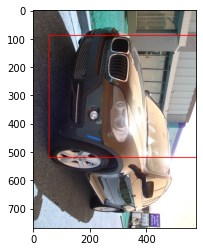

In [ ]:
display_image_with_bounding_box('07389.jpg')

#### The image is rotated, hence the discrepency. We'll correct it by rotating it.

In [ ]:
image_path = "Car Images/Train Images/BMW X5 SUV 2007/07389.jpg"
image = cv2.imread(image_path)

image_rot = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE) # rotate the image and save it
cv2.imwrite(image_path, image_rot)

True

Name:  BMW X5 SUV 2007
Shape:  (576, 768, 3)
Bounding Box:  [56, 89, 717, 519]


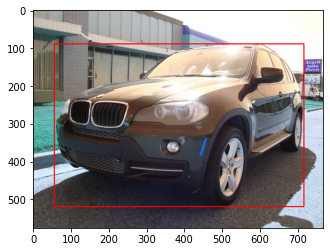

In [ ]:
display_image_with_bounding_box('07389.jpg') # display the image after adjustment

In [ ]:
# As we rotated the image, Flip the height and width in the metadata as well
row_index = train_metadata[train_metadata['image_name'] == '07389.jpg'].index[0]

original_width = train_metadata.at[row_index, 'image_width']
original_height = train_metadata.at[row_index, 'image_height']

# Flip
train_metadata.at[row_index, 'image_width'] = original_height
train_metadata.at[row_index, 'image_height'] = original_width

In [ ]:
train_metadata[(train_metadata['xmin'] > train_metadata['xmax']) | (train_metadata['xmax'] > train_metadata['image_width'])] # verify that condition is satisfied after correction

Empty DataFrame
Columns: [image_path, image_name, image_height, image_width, image_channels, xmin, ymin, xmax, ymax, class, car_name]
Index: []

## 5. Design, train and test basic CNN models to classify the car

### MOBILENET V2

In [ ]:
# Using augmentation on train set
train_datagen=ImageDataGenerator(rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=mobilenet_v2.preprocess_input)

valid_datagen=ImageDataGenerator(horizontal_flip=True, 
                                  preprocessing_function=mobilenet_v2.preprocess_input)

train_generator=train_datagen.flow_from_directory(
    directory=TRAIN_FOLDER_PATH,
    batch_size=64,
    seed=42,
    target_size=(224,224))


valid_generator=valid_datagen.flow_from_directory(
    directory=TEST_FOLDER_PATH,
    batch_size=300,
    seed=42,
    target_size=(224,224))

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
for x,y in valid_generator:
    x_val = x
    y_val = y
    break;

In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3), alpha = 0.5, include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(.6)(x)
prediction_layer = Dense(196, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=prediction_layer)

# Freezing first 80 layers out of total 156 layers
for layer in model.layers[:80]:
    layer.trainable=False
for layer in model.layers[80:]:
    layer.trainable=True

model.compile(optimizer = Adam(lr=0.0001, clipnorm=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

3201480/3201480 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=100,
          validation_data=(x_val,y_val),
          epochs=40,verbose=1,
          workers=multiprocessing.cpu_count())

Epoch 1/40
100/100 [==============================] - 100s 823ms/step - loss: 5.7576 - accuracy: 0.0074 - val_loss: 5.3402 - val_accuracy: 0.0100
Epoch 2/40
100/100 [==============================] - 83s 825ms/step - loss: 5.3191 - accuracy: 0.0142 - val_loss: 5.1847 - val_accuracy: 0.0200
Epoch 3/40
100/100 [==============================] - 84s 836ms/step - loss: 5.0863 - accuracy: 0.0282 - val_loss: 4.9885 - val_accuracy: 0.0367
Epoch 4/40
100/100 [==============================] - 85s 840ms/step - loss: 4.8492 - accuracy: 0.0506 - val_loss: 4.6850 - val_accuracy: 0.0533
Epoch 5/40
100/100 [==============================] - 84s 831ms/step - loss: 4.5621 - accuracy: 0.0814 - val_loss: 4.3946 - val_accuracy: 0.0900
Epoch 6/40
100/100 [==============================] - 86s 840ms/step - loss: 4.2925 - accuracy: 0.1047 - val_loss: 4.1448 - val_accuracy: 0.1233
Epoch 7/40
100/100 [==============================] - 84s 825ms/step - loss: 4.0267 - accuracy: 0.1321 - val_loss: 3.8453 - val_a

In [ ]:
def plot_loss(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1,len(loss)+1)

  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_accuracy(history):
  
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1,len(accuracy)+1)
  
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
  plt.show()

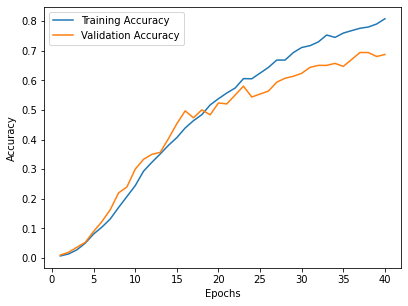

In [ ]:
plot_accuracy(history)

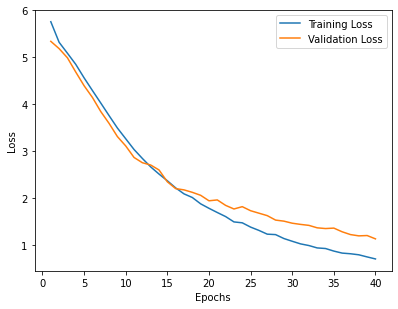

In [ ]:
plot_loss(history)

In [ ]:
for i,j in valid_generator:
    pred = model.predict(i)
    pred = pred.argmax(-1)
    true = j.argmax(-1)
    print(classification_report(true, pred))
    break;

10/10 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
           8       1.00      0.50      0.67         2
           9       0.50      1.00      0.67         1
          11       0.00      0.00      0.00         2
          12       0.33      0.50      0.40         2
          13       1.00      1.00      1.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          16       0.50      1.00      0.67         1
          17       1.00      0.33      0.50         3
          18       1.00    

### RESNET50

In [ ]:
train_datagen=ImageDataGenerator(rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=resnet.preprocess_input)

valid_datagen=ImageDataGenerator(horizontal_flip=True, 
                                  preprocessing_function=resnet.preprocess_input)

train_generator=train_datagen.flow_from_directory(
    directory=TRAIN_FOLDER_PATH,
    batch_size=64,
    seed=42,
    target_size=(224,224))


valid_generator=valid_datagen.flow_from_directory(
    directory=TEST_FOLDER_PATH,
    batch_size=300,
    seed=42,
    target_size=(224,224))

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
for x,y in valid_generator:
    x_val = x
    y_val = y
    break;

In [ ]:
base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
prediction_layer = Dense(196, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=prediction_layer)

# Freezing first 150 layers
for layer in model.layers[:150]:
    layer.trainable=False
for layer in model.layers[150:]:
    layer.trainable=True

model.compile(optimizer = Adam(lr=0.0001, clipnorm=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
for i,layer in enumerate(model.layers): # Frozen 150 layers out of total 177 layers
  print(i, layer.name, layer.trainable) 

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=100,
          validation_data=(x_val,y_val),
          epochs=40,verbose=1,
          workers=multiprocessing.cpu_count())

Epoch 1/40
100/100 [==============================] - 96s 888ms/step - loss: 5.8212 - accuracy: 0.0083 - val_loss: 4.8994 - val_accuracy: 0.0333
Epoch 2/40
100/100 [==============================] - 88s 857ms/step - loss: 4.9720 - accuracy: 0.0414 - val_loss: 4.0736 - val_accuracy: 0.1567
Epoch 3/40
100/100 [==============================] - 105s 1s/step - loss: 4.2395 - accuracy: 0.1137 - val_loss: 3.2783 - val_accuracy: 0.2433
Epoch 4/40
100/100 [==============================] - 91s 886ms/step - loss: 3.5661 - accuracy: 0.2014 - val_loss: 2.8139 - val_accuracy: 0.3400
Epoch 5/40
100/100 [==============================] - 87s 854ms/step - loss: 2.9902 - accuracy: 0.2988 - val_loss: 2.5313 - val_accuracy: 0.4000
Epoch 6/40
100/100 [==============================] - 89s 874ms/step - loss: 2.5710 - accuracy: 0.3785 - val_loss: 2.3459 - val_accuracy: 0.4500
Epoch 7/40
100/100 [==============================] - 87s 858ms/step - loss: 2.1864 - accuracy: 0.4682 - val_loss: 1.9734 - val_accu

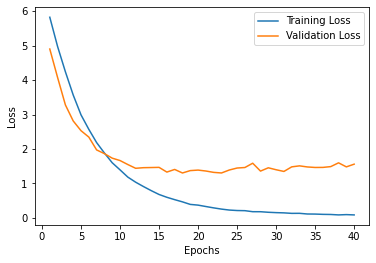

In [ ]:
plot_loss(history)

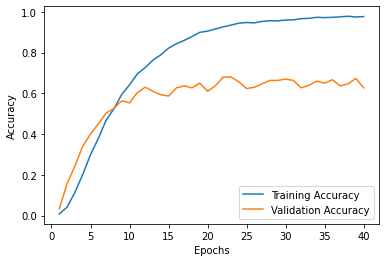

In [ ]:
plot_accuracy(history)

In [ ]:
for i,j in valid_generator:
    pred = model.predict(i)
    pred = pred.argmax(-1)
    true = j.argmax(-1)
    print(classification_report(true, pred))
    break;

10/10 [==============================] - 2s 97ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      0.25      0.40         4
          13       0.75      1.00      0.86         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00    

#### Comparing MobilenetV2 and Resnet50

- Resnet is aggressively learning and overfitting. We can see the validation_accuracy not growing while the training accuracy keeps increasing.We can reduce overfitting by doing more augmentation etc.
- Mobilenet showed smooth accuracy and loss curve for validation data.
- MobilenetV2 is clearly the winner as it has validation_accuracy of 68% while resenet being 62%. Mobilenet has better recall and F1 score.
- Please go through the interim report for deeper analysis on these two models.

## Milestone 2

### YoloV5

#### Install the necessary requirements for yolov5

In [ ]:
!pip install openimages
!git clone https://github.com/ultralytics/yolov5
!pip install -U -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 132 kB 63.1 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 9.9 MB 50.7 MB/s 
     |████████████████████████████████| 140 kB 76.7 MB/s 
     |████████████████████████████████| 296 kB 73.3 MB/s 
     |████████████████████████████████| 221.4 MB 37 kB/s 
     |████████████████████████████████| 439 kB 63.3 MB/s 
     |████████████████████████████████| 6.0 MB 59.7 MB/s 
     |████████████████████████████████| 1.7 MB 62.0 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
   

Cloning into 'yolov5'...
remote: Enumerating objects: 14027, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 14027 (delta 174), reused 166 (delta 111), pack-reused 13766
Receiving objects: 100% (14027/14027), 13.64 MiB | 17.83 MiB/s, done.
Resolving deltas: 100% (9601/9601), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 30.3 MB/s 
     |████████████████████████████████| 793 kB 65.8 MB/s 
     |████████████████████████████████| 11.2 MB 55.7 MB/s 
     |████████████████████████████████| 3.2 MB 56.4 MB/s 
     |████████████████████████████████| 280 kB 72.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:46tcmalloc: large alloc 1147494400 bytes == 0x39aae000 @  0x7fe4a2c15615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x51032

#### Pre-processing

#### Build a dictionary of image_name to bounding box coordinates

In [ ]:
anno_dict = {}

filename = '/content/Annotations/Train Annotations.csv'
with open(filename, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for i,row in enumerate(datareader):
      if(i > 0):

        img_name = row[0]
        xmin = float(row[1])
        ymin = float(row[2])
        xmax = float(row[3])
        ymax = float(row[4])
        label = int(row[5]) - 1

        anno_dict[img_name] = (label, xmin, ymin, xmax, ymax)

filename = '/content/Annotations/Test Annotation.csv'
with open(filename, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for i,row in enumerate(datareader):
      if(i > 0):

        img_name = row[0]
        xmin = float(row[1])
        ymin = float(row[2])
        xmax = float(row[3])
        ymax = float(row[4])
        label = int(row[5]) - 1

        # since both train and test source images have same names but diff folders, we add 'test_' as prefix before copying for differentiation
        anno_dict["test_" + img_name] = (label, xmin, ymin, xmax, ymax)

#### Function to convert bounding box coordinates
- The given coordinates are in format (xmin, ymin) and (xmax, ymax) i.e. left bottom and top right corners of the box.
- For yolo to understand, they should be converted into the format (x,y) and (w,h) i.e. (x,y) being the center of the box and w,h denotes the width and height of the box.
- Since, yolo is pre-trained with this kind of annotations for coco images, we need to follow the same format before feeding it.

In [ ]:
def to_coco_bbox(xmin, ymin, xmax, ymax, image_height, image_width):
  
  # calculate center, width and height of bbox
  x = (xmin + xmax)/2
  y = (ymin + ymax)/2
  w = (xmax - xmin)
  h = (ymax - ymin)

  # normalize wrt image size
  x /= image_width
  y /= image_height
  w /= image_width
  h /= image_height

  return x,y,w,h

In [ ]:
# ----------------------------------------------------------------
# Create a 'data' folder structure as follows to feed yolo model.
# ----------------------------------------------------------------
# data
#   +-- images
#         +-- test
#         +-- train
#         +-- val
#   +-- labels
#         +-- test
#         +-- train
#         +-- val
# ----------------------------------------------------------------

def create_folder_structure():
  if os.path.exists('data'): # if folder already exists, delete it.
    shutil.rmtree('data')

  for folder in ['images', 'labels']:
      for split in ['train', 'val', 'test']:
          os.makedirs(f'data/{folder}/{split}')

In [ ]:
# creates a data yaml file for yolo
def create_data_yaml(labels):

  fp = open('cars_data.yaml', 'w')

  fp.write("# Dataset paths relative to the yolov5 folder \n")
  fp.write("train: ../data/images/train \n")
  fp.write("val:   ../data/images/val \n")
  fp.write("test:  ../data/images/test \n")

  fp.write("\n# Number of classes\n")
  fp.write("nc: " + str(len(labels)) + "\n")

  fp.write("names: " + str(labels))

  fp.close()

In [ ]:
# This function does the data preparation as follows:
#
#  1. Create a folder structure as mentioned above.
#  2. For each class, combine all the source data images from both train and test folders.
#  3. Split the images and annotations into the given (train,val,test) ratio.
#  4. After splitting, write the images and labels into the corresponding train, val and test sub folders for the model to use.
#  5. At the end, print the overall split stats, create a data yaml for for yolo and return the class wise split info. 
#
#  Note: We can use 'first_n_classes' to load only the first few number of classes data. 
#        For instance, we can load only the first 5 classes of data and create a corresponding baseline model for any future estimations.
#        It's default value is 196 which covers all the data.

def prepare_data_yolov5(train_split=0.7, val_split=0.2, test_split=0.1, first_n_classes=196):
  
  class_split_info = {}

  create_folder_structure()

  all_cars = list(car_names_dict.values())

  # iterate over each class
  for current_car in all_cars[0:first_n_classes]:

    train_path = '/content/Car Images/Train Images/' + current_car
    test_path = '/content/Car Images/Test Images/' + current_car

    train_images_names = os.listdir(train_path)
    test_images_names = os.listdir(test_path)

    total_size = len(train_images_names) + len(test_images_names)

    # calculate new (train,val,split) sizes
    new_train_size = int(total_size * train_split)
    new_test_size = int(total_size * test_split)
    new_val_size = total_size - (new_train_size + new_test_size)
    
    # store split info for the current class
    class_split_info[current_car] = {"total_size": total_size, "train_size": new_train_size, "val_size": new_val_size, "test_size": new_test_size}

    # combine all the image names of the current class
    # since both train and test source images have same names but diff folders, we add 'test_' as prefix before copying for differentiation 
    all_image_names = train_images_names + ["test_" + i for i in test_images_names]

    for i,image_name in enumerate(all_image_names):

      # determine the destination directory 
      if (i < new_train_size):
        dst_dir = '/content/data/images/train'
      
      elif (i < new_train_size + new_val_size):
        dst_dir = '/content/data/images/val'
      
      else:
        dst_dir = '/content/data/images/test'
      

      # copy image from source to destination
      if("test_" in image_name):
        src = test_path + "/" + image_name.replace("test_", "") # remove 'test_' to determine the source image path of test images
      else:
        src = train_path + "/" + image_name

      dst = dst_dir + "/" + image_name
      
      shutil.copy(src, dst)


      # create a new label file for the corresponding image and copy it's bbox coordinates
      image = cv2.imread(dst)
      image_height, image_width = image.shape[0], image.shape[1]
      
      label, xmin, ymin, xmax, ymax = anno_dict[image_name]
      
      x,y,w,h = to_coco_bbox(xmin, ymin, xmax, ymax, image_height, image_width)
      anno = str(label) +' '+ str(x) +' '+ str(y) +' '+ str(w) +' '+ str(h)

      dst = dst.replace("images", "labels")
      dst = dst.replace("jpg", "txt")
            
      fp = open(dst, 'w')
      fp.write(anno)
      fp.close()

  class_split_info = pd.DataFrame(class_split_info).T
  
  print('     Total size:', class_split_info['total_size'].sum())
  print('     Train size:', class_split_info['train_size'].sum())
  print('Validation size:', class_split_info['val_size'].sum())
  print('      Test size:', class_split_info['test_size'].sum())

  labels = list(class_split_info.index)
  create_data_yaml(labels)

  return class_split_info

#### Base Model with only 3 classes
- Checking if yolov5 performs well at the basic level with only 3 classes.

In [ ]:
prepare_data_yolov5(train_split=0.7, val_split=0.2, test_split=0.1, first_n_classes=3)

     Total size: 239
     Train size: 166
Validation size: 51
      Test size: 22


total_size  train_size  val_size  test_size
AM General Hummer SUV 2000          89          62        19          8
Acura RL Sedan 2012                 64          44        14          6
Acura TL Sedan 2012                 86          60        18          8

In [ ]:
!cat cars_data.yaml

# Dataset paths relative to the yolov5 folder 
train: ../data/images/train 
val:   ../data/images/val 
test:  ../data/images/test 

# Number of classes
nc: 3
names: ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012']

##### Train the model

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 100

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

##### Inferences from above exercise
- We achieved a precision of 92% and mAP50 of 94% indicating that the base model is performing well.
- The recall and mAP50 are high for the images with more number of training images.
- The recommended split for yolov5 is (train: 70, val: 20, test: 10), which can give more images to train.
- This gives us some confidence to apply the same model for bigger dataset.

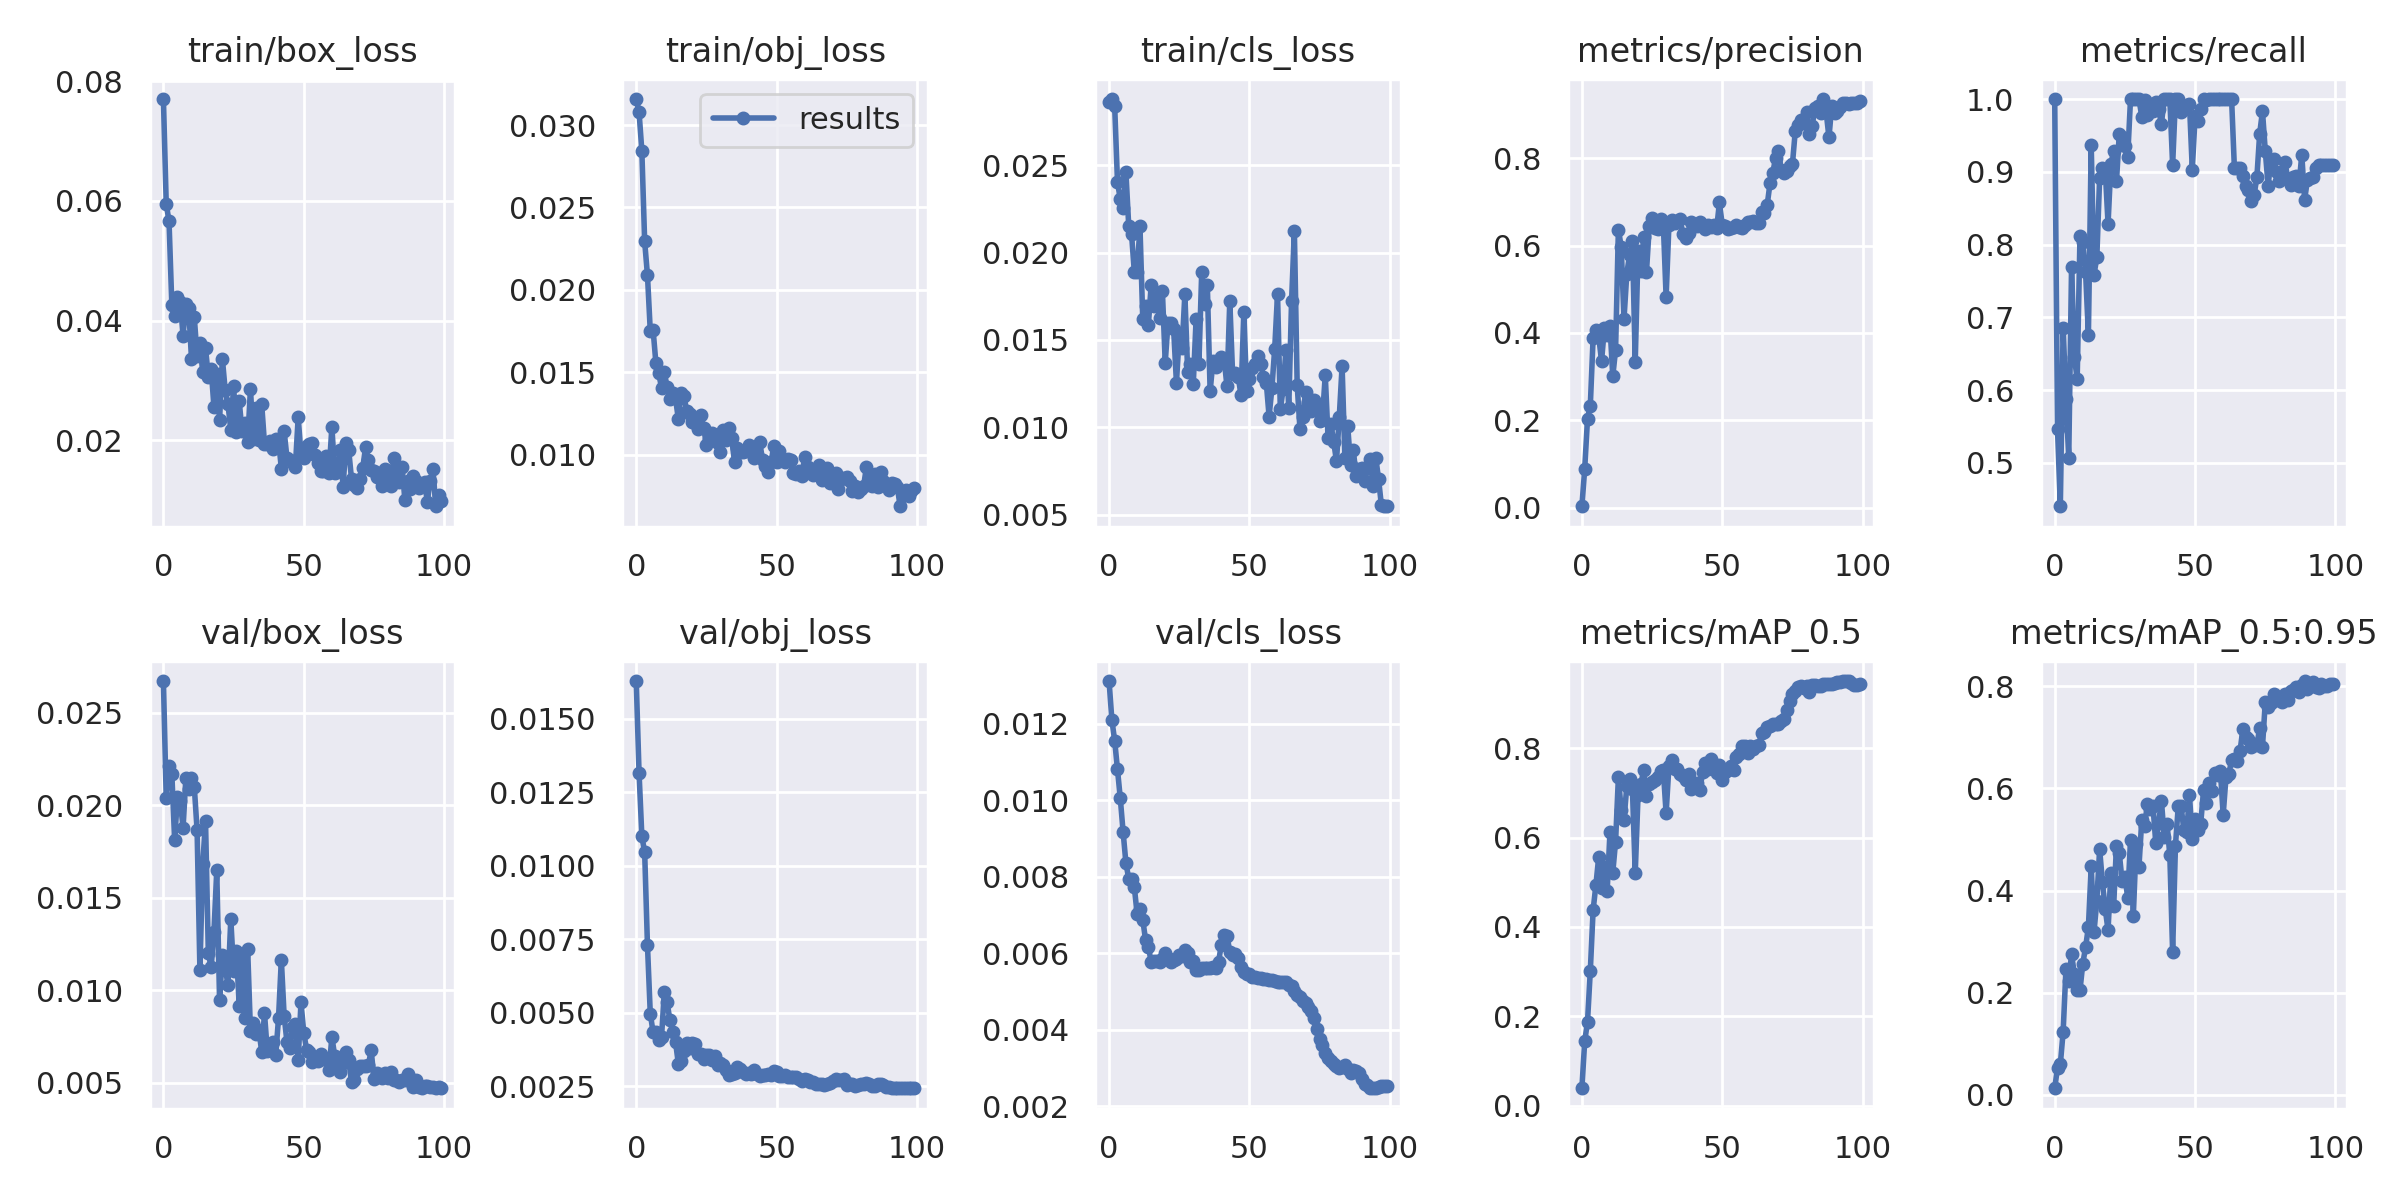

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/results.png')

##### Predict some of the test images

In [ ]:
!python yolov5/detect.py --source '/content/data/images/test' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img-size 320

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/data/images/test, data=yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/22 /content/data/images/test/test_00347.jpg: 128x320 1 Acura RL Sedan 2012, 1 Acura TL Sedan 2012, 11.0ms
image 2/22 /content/data/images/test/test_00397.jpg: 224x320 1 Acura RL Sedan 2012, 11.3ms
image 3/22 /content/data/images/test/test_00684.jpg: 192x320 1 AM General Hummer SUV 2000, 11.7ms
image 4

##### Evaluation on test images

In [ ]:
!python yolov5/val.py --batch 32 --data cars_data.yaml --weights '/content/yolov5/runs/train/exp/weights/best.pt' --task test --img-size 320

val: data=cars_data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/data/labels/test... 22 images, 0 backgrounds, 0 corrupt: 100% 22/22 [00:00<00:00, 403.79it/s]
test: New cache created: /content/data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.89it/s]
                   all         22         22      0.727      0.919      0.846      0.738
AM General Hummer SUV 2000         22          8      

##### Inferences
- The overall recall is 92% and mAP50 being 85% for the test images.
- Indicates that model is performing well enough.

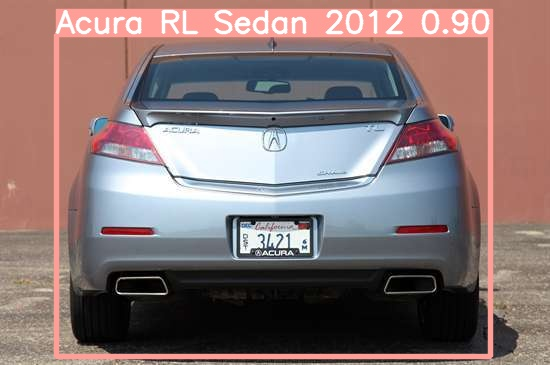

In [ ]:
Image(filename='/content/yolov5/runs/detect/exp2/test_00397.jpg', width=500)

#### Before jumping to the final model. Experiment with some parameters to reduce training time

In [ ]:
prepare_data_yolov5(train_split=0.7, val_split=0.2, test_split=0.1, first_n_classes=196) # select all 196 classes

     Total size: 16185
     Train size: 11226
Validation size: 3435
      Test size: 1524


total_size  train_size  val_size  test_size
AM General Hummer SUV 2000                89          62        19          8
Acura RL Sedan 2012                       64          44        14          6
Acura TL Sedan 2012                       86          60        18          8
Acura TL Type-S 2008                      84          58        18          8
Acura TSX Sedan 2012                      81          56        17          8
...                                      ...         ...       ...        ...
Volkswagen Beetle Hatchback 2012          85          59        18          8
Volvo C30 Hatchback 2012                  83          58        17          8
Volvo 240 Sedan 1993                      91          63        19          9
Volvo XC90 SUV 2007                       86          60        18          8
smart fortwo Convertible 2012             80          56        16          8

[196 rows x 4 columns]

In [ ]:
!cat cars_data.yaml

# Dataset paths relative to the yolov5 folder 
train: ../data/images/train 
val:   ../data/images/val 
test:  ../data/images/test 

# Number of classes
nc: 196
names: ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Co

##### Experiments to better utilise the resources
There's always a trade off between the available GPU RAM (12.68 GB) and training time. Hence, playing with the following fields to reduce the training time as much as possible, but not consume too much RAM.
- Caching the images.
- Image size - [640 (default), 320] 
- Batch size - [16 (default), 32, 64]
- Workers (No of parallel threads) - [8 (default), 16, 32]


In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

###### The above run almost crashed the RAM. Hence interrupted and going for the next parameters.

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache --img-size 320 # reduce image size

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache --img-size 320 --batch 16

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache --img-size 320 --batch 32

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache --img-size 320 --batch 64

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=64, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache --img-size 320 --batch 64 --workers 16

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=64, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=16, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 2 --cache --img-size 320 --batch 64 --workers 32

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=64, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=32, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-266-g72cad39 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

In [46]:
experiment = {
    '0': {'img_size': 640, 'batch_size': 16, 'workers': 8, 'cache': 'yes', 'epoch time in min': 8.47, 'GPU per epoch in GB': 8.87},
    '1': {'img_size': 320, 'batch_size': 16, 'workers': 8, 'cache': 'yes', 'epoch time in min': 1.39, 'GPU per epoch in GB': 2.1},

    '2': {'img_size': 320, 'batch_size': 32, 'workers': 8, 'cache': 'yes', 'epoch time in min': 1.10, 'GPU per epoch in GB': 3.24},
    '3': {'img_size': 320, 'batch_size': 64, 'workers': 8, 'cache': 'yes', 'epoch time in min': 1.03, 'GPU per epoch in GB': 6.84},

    '4': {'img_size': 320, 'batch_size': 64, 'workers': 8, 'cache': 'yes', 'epoch time in min': 1, 'GPU per epoch in GB': 6.84},
    '5': {'img_size': 320, 'batch_size': 64, 'workers': 8, 'cache': 'yes', 'epoch time in min': 0.59, 'GPU per epoch in GB': 6.84}
    }
pd.DataFrame(experiment).T

img_size batch_size workers cache epoch time in min GPU per epoch in GB
0      640         16       8   yes              8.47                8.87
1      320         16       8   yes              1.39                 2.1
2      320         32       8   yes               1.1                3.24
3      320         64       8   yes              1.03                6.84
4      320         64       8   yes                 1                6.84
5      320         64       8   yes              0.59                6.84

##### From the above exercise we finally reduced each epoch time to under a minute i.e. 59 secs and RAM of 6.84 GB of GPU.
- Best configuration: --batch 64 --img-size 320 --cache --workers 32 

#### The Final Model

In [ ]:
prepare_data_yolov5(train_split=0.7, val_split=0.2, test_split=0.1, first_n_classes=196)

     Total size: 16185
     Train size: 11226
Validation size: 3435
      Test size: 1524


total_size  train_size  val_size  test_size
AM General Hummer SUV 2000                89          62        19          8
Acura RL Sedan 2012                       64          44        14          6
Acura TL Sedan 2012                       86          60        18          8
Acura TL Type-S 2008                      84          58        18          8
Acura TSX Sedan 2012                      81          56        17          8
...                                      ...         ...       ...        ...
Volkswagen Beetle Hatchback 2012          85          59        18          8
Volvo C30 Hatchback 2012                  83          58        17          8
Volvo 240 Sedan 1993                      91          63        19          9
Volvo XC90 SUV 2007                       86          60        18          8
smart fortwo Convertible 2012             80          56        16          8

[196 rows x 4 columns]

In [ ]:
!cat cars_data.yaml

# Dataset paths relative to the yolov5 folder 
train: ../data/images/train 
val:   ../data/images/val 
test:  ../data/images/test 

# Number of classes
nc: 196
names: ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Co

In [ ]:
!python yolov5/train.py --data cars_data.yaml --weights yolov5s.pt --epochs 150 --batch 64 --img-size 320 --cache --workers 32

train: weights=yolov5s.pt, cfg=, data=cars_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=64, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=32, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-263-g0307954 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_

### Model pickling
- Note that the model is automatically saved to the folder "yolov5/runs/train/exp" by yolov5 library.
- From here, we can download the 'yolov5/runs/train/exp/weights/best.pt' weights and reload them for future use. 
- Hence, "pickling" the model is given out of box to us by yolo library.
- To check how we can reload the pretrained model, Please refer to the "Basic clickable UI" section at the end of this notebook.

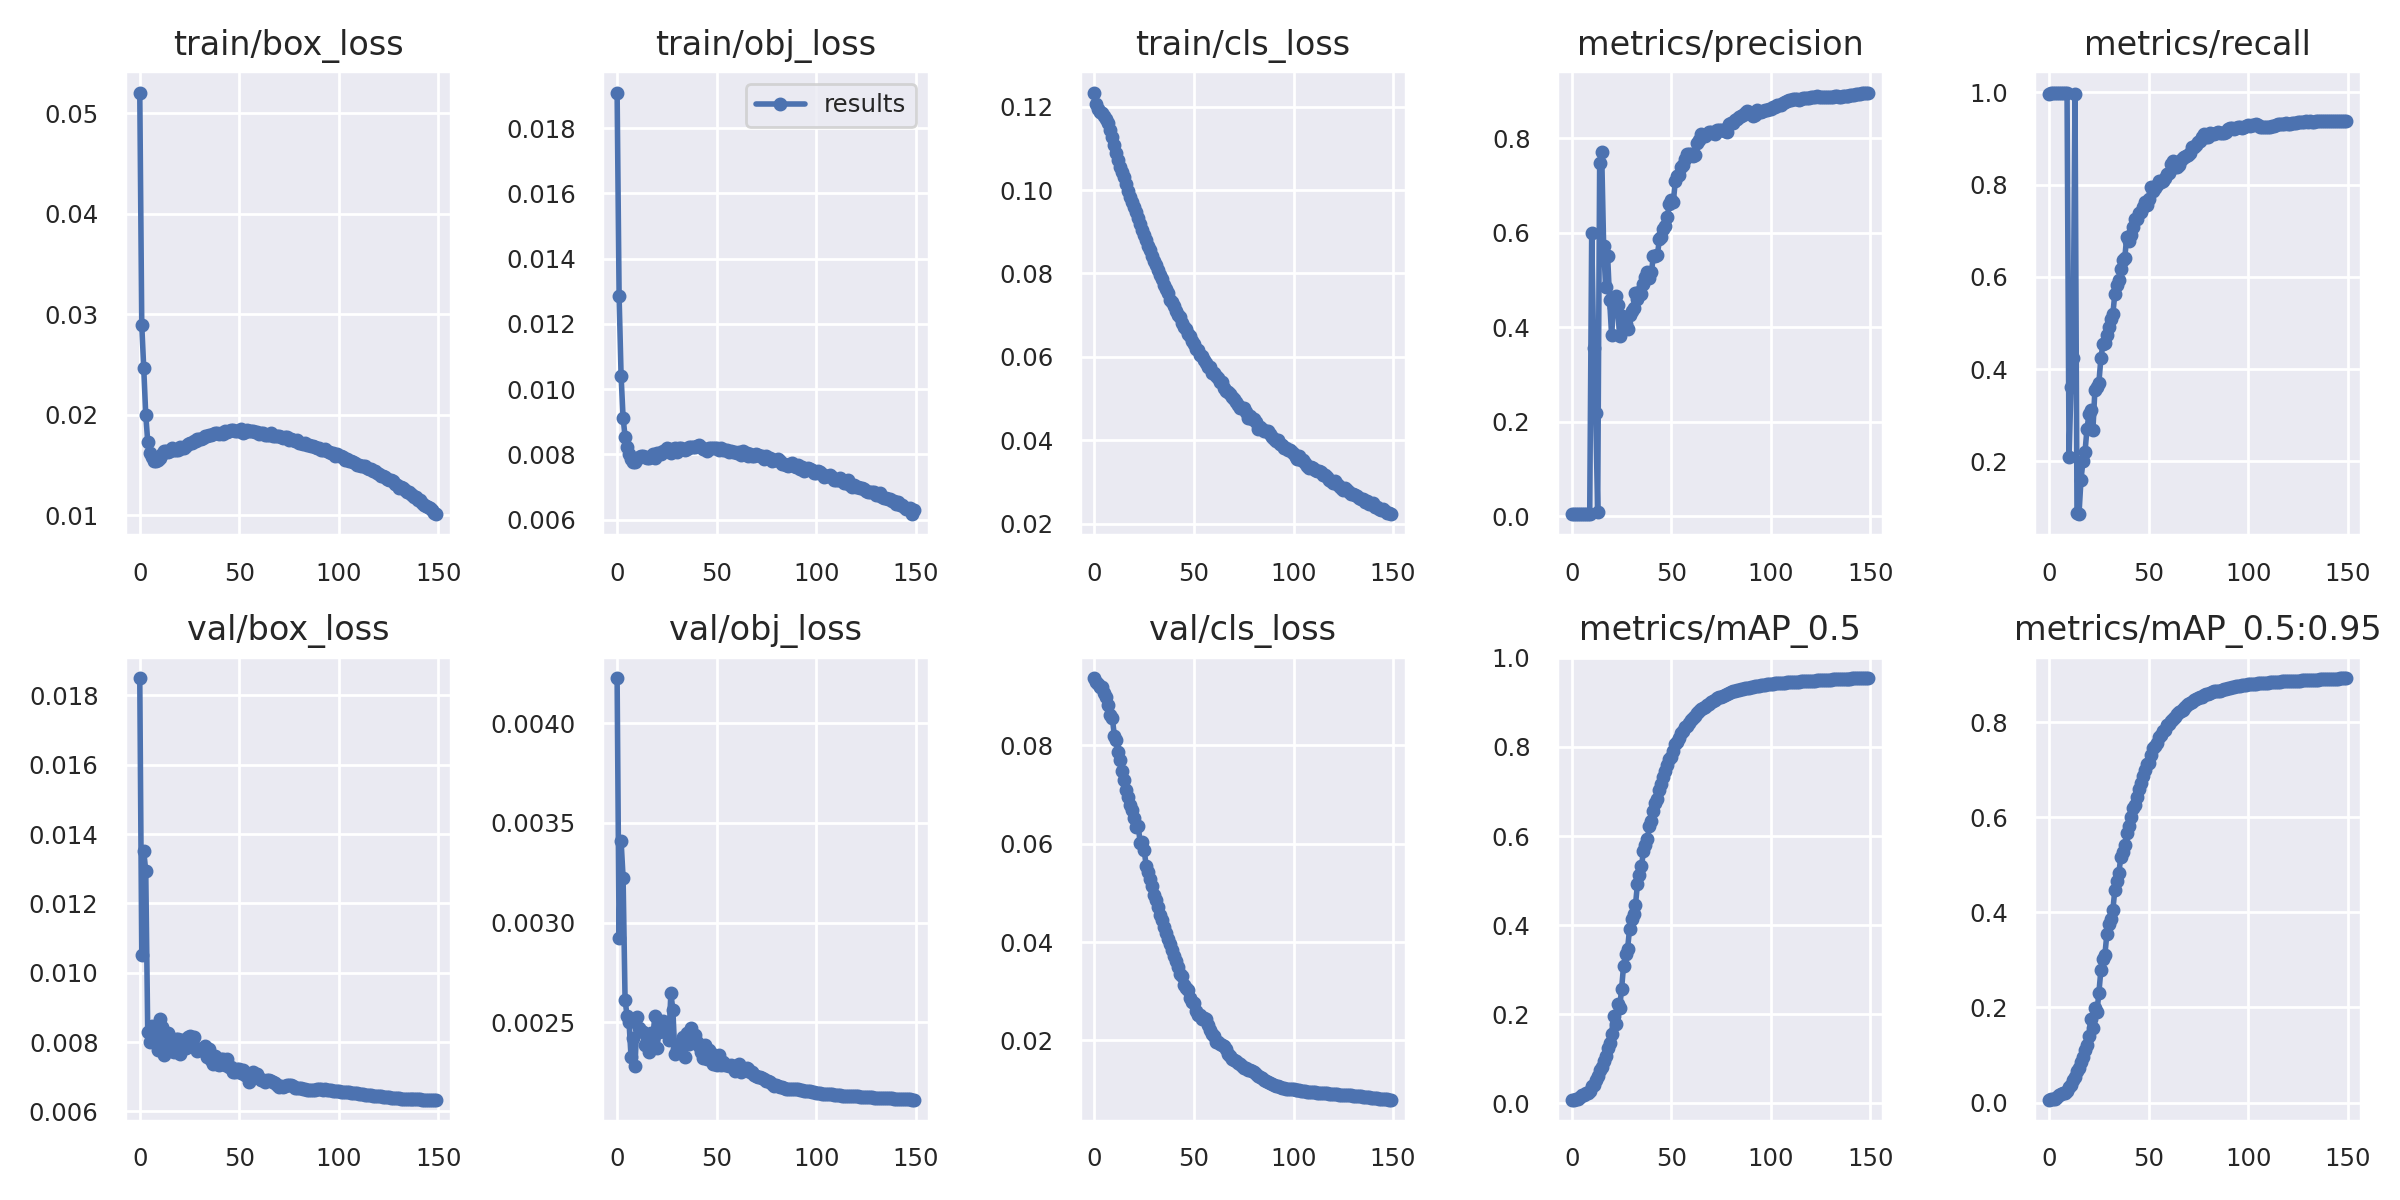

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/results.png')

##### Evaluate on test images

In [ ]:
!python yolov5/val.py --batch 64 --data cars_data.yaml --weights '/content/yolov5/runs/train/exp/weights/best.pt' --task test --img-size 320

val: data=cars_data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=64, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-263-g0307954 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7538737 parameters, 0 gradients, 17.4 GFLOPs
test: Scanning /content/data/labels/test... 1524 images, 0 backgrounds, 0 corrupt: 100% 1524/1524 [00:04<00:00, 376.31it/s]
test: New cache created: /content/data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 24/24 [00:21<00:00,  1.12it/s]
                   all       1524       1524      0.877       0.93      0.956      0.902
Speed: 0.1ms pre-process, 1.6ms inference, 2.1

##### Predict all the test images

In [ ]:
!python yolov5/detect.py --source '/content/data/images/test' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img-size 320

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/data/images/test, data=yolov5/data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-263-g0307954 Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7538737 parameters, 0 gradients, 17.4 GFLOPs
image 1/1524 /content/data/images/test/test_00018.jpg: 224x320 1 BMW X6 SUV 2012, 10.9ms
image 2/1524 /content/data/images/test/test_00044.jpg: 256x320 1 Chevrolet Avalanche Crew Cab 2012, 12.1ms
image 3/1524 /content/data/images/test/test_00047.jpg: 256x320 1 Chevrolet Silverado 2500HD Regular Cab 2012, 1 Ch

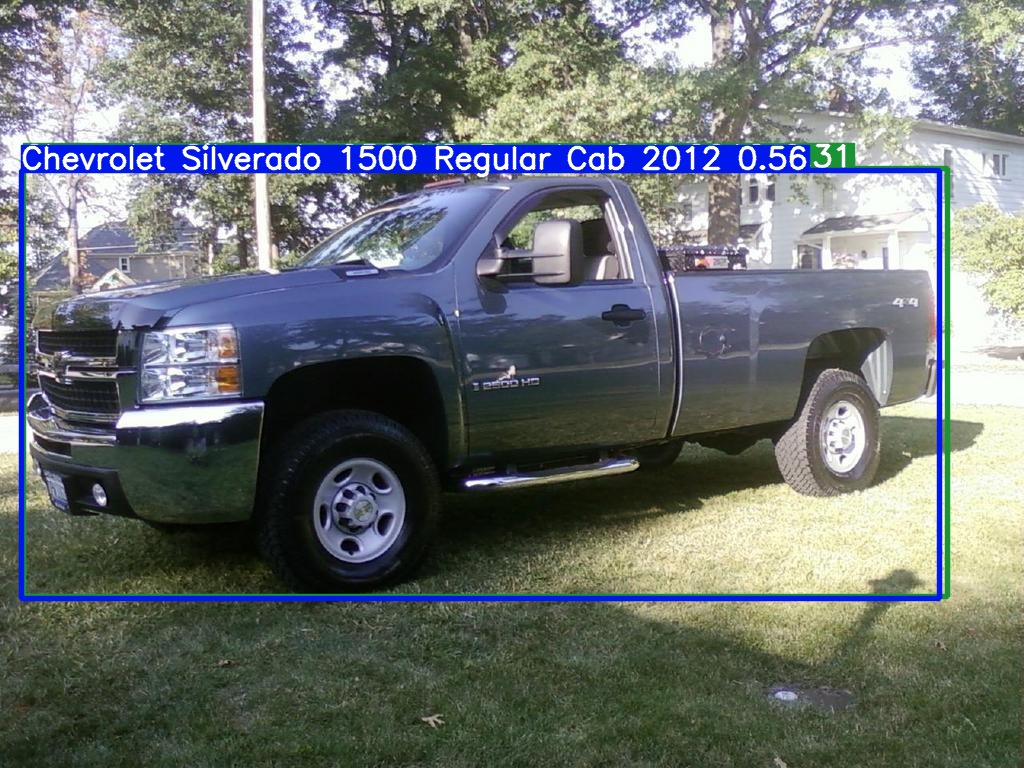

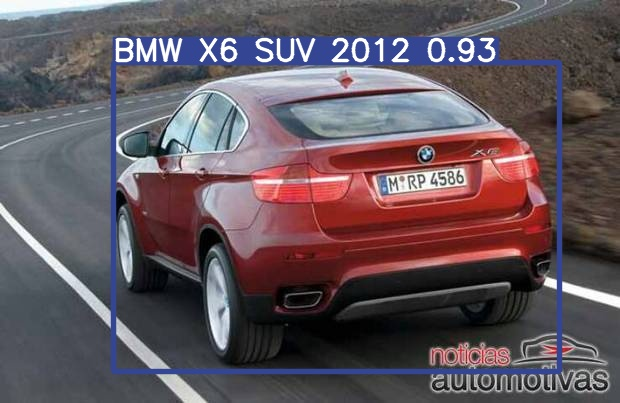

In [ ]:
for i in ['/content/yolov5/runs/detect/exp/test_00047.jpg', '/content/yolov5/runs/detect/exp/test_00018.jpg']:
  img = Image(filename=i, width=500)
  display(img)

## Final inferences
### We achieved a recall of 93% and mAP50 of 96% on the test images with YOLO V5 S model.
### Speed: 0.1ms pre-process, 1.6ms inference, 2.1ms NMS per image.
### The model is very light weight as well with 15.3 MB. (size of 'best.pt' weights)

### Basic Clickable UI using Gradio

In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 37.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 1.6 MB 54.6 MB/s 


In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 29.1 MB/s 
     |████████████████████████████████| 2.3 MB 59.4 MB/s 
     |████████████████████████████████| 272 kB 74.1 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 213 kB 74.4 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 106 kB 66.5 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 80 kB 10.3 MB/s 
     |████████████████████████████████| 68 kB 8.6 MB/s 
     |████████████████████████████████| 68 kB 8.0 MB/s 
     |████████████████████████████████| 68 kB 7.6 MB/s 
     |████████████████████████████████| 46 kB 4.9

In [ ]:
import torch

best_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5_best.pt') # Load the saved best model

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-20 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7538737 parameters, 0 gradients, 17.4 GFLOPs
Adding AutoShape... 


In [ ]:
def predict(input_image): # function to take image input and output an image with predictions

  pred = best_model(input_image, size=320)
  pred_image = pred.render()[0]

  return pred_image

In [ ]:
import gradio as gr

# Launch the basic UI for prediction
gr.Interface(fn=predict, 
             inputs=gr.Image(),
             outputs=gr.Image(shape=(224, 224))).launch() # Note that this would launch an interface. This seems not visible after saving the notebook. Attached the screenshot in report.

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>